#  K-Nearest Neighbors Classifier for Mushroom Dataset

Import the required libraries. Pandas will be used for reading data file and various other operations on the dataframe. Numpy will be used for mathematical operations on the data. sklearn.metrics and sklearn will be used for calculating accuracy and comparing the performance of the sklearn KNN classifier with my own implementation of the same. math and random libraries will be used for various other operations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# Data Preprocessing

Read the data from the path and see the contents and columns and the datatypes.Check which values are null.Which of the columns are sparse and decide on the basis of this which columns to drop.

In [2]:
df=pd.read_csv("train.csv",header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,c,l
1,e,k,s,g,f,n,f,w,b,p,...,s,w,w,p,w,t,p,w,s,g
2,e,b,s,g,f,n,f,w,b,w,...,s,w,w,p,w,t,p,w,s,g
3,e,s,f,g,f,n,f,c,n,n,...,s,w,w,p,w,o,p,n,v,u
4,e,f,f,g,f,n,f,w,b,p,...,f,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4491,p,x,y,y,f,f,f,c,b,p,...,k,n,n,p,w,o,l,h,y,g
4492,p,f,y,e,f,y,f,c,n,b,...,k,p,w,p,w,o,e,w,v,d
4493,p,x,y,g,f,f,f,c,b,h,...,k,p,p,p,w,o,l,h,y,p
4494,p,x,y,e,f,f,f,c,n,b,...,s,w,p,p,w,o,e,w,v,d


The data contains all the values in the attributes as alphabets/characters.Since KNN calculates distance inorder to measure the similarty index and classify into respective classes,we somehow need to convert it to numeric data.So I decided to convert it into ascii values and hence convert into numeric value."letters" is a dictionary which helps in replacing all the occurances of characters with its respective ascii value.Since there also exists missing values in the form of "?" we need to replace it as well,so we change it with the mode of that attribute.'e' means mushroom is edible,'p' means mushroom is poisonous.

In [3]:
letters={"a":int(ord('a')),"b":int(ord('b')),"c":int(ord('c')),"d":int(ord('d')),"e":int(ord('e')),"f":int(ord('f')),"g":int(ord('g')),"h":int(ord('h'))
                                             ,"i":int(ord('i')),"j":int(ord('j')),"k":int(ord('k')),"l":int(ord('l')),"m":int(ord('m')),"n":int(ord('n')),"o":int(ord('o')),"p":int(ord('p')),"q":int(ord('q')),"r":int(ord('r'))
                                             ,"s":int(ord('s')),"t":int(ord('t')),"u":int(ord('u')),"v":int(ord('v')),"w":int(ord('w')),"x":int(ord('x')),"y":int(ord('y')),"z":int(ord('z'))} 
for column in df.columns:
    df[column]=df[column].replace(to_replace ="?",  
                            value =df[column].mode()[0])
for column in df.columns:
    df[column]=df[column].replace(to_replace=letters)
df = df.apply(pd.to_numeric)

In [4]:
df

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,101,107,115,110,102,110,97,99,98,121,...,115,111,111,112,110,111,112,98,99,108
1,101,107,115,103,102,110,102,119,98,112,...,115,119,119,112,119,116,112,119,115,103
2,101,98,115,103,102,110,102,119,98,119,...,115,119,119,112,119,116,112,119,115,103
3,101,115,102,103,102,110,102,99,110,110,...,115,119,119,112,119,111,112,110,118,117
4,101,102,102,103,102,110,102,119,98,112,...,102,119,119,112,119,111,101,110,97,103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4491,112,120,121,121,102,102,102,99,98,112,...,107,110,110,112,119,111,108,104,121,103
4492,112,102,121,101,102,121,102,99,110,98,...,107,112,119,112,119,111,101,119,118,100
4493,112,120,121,103,102,102,102,99,98,104,...,107,112,112,112,119,111,108,104,121,112
4494,112,120,121,101,102,102,102,99,110,98,...,115,119,112,112,119,111,101,119,118,100


# Helper Functions

The function below splits the data into training data and testing data in two parts as per the size passed.

In [5]:
#train test split
def train_test_split(df,test_size):
    df_size=len(df)
    if isinstance(test_size,float):#if test size is passed as a proportion
        test_size=round(test_size*df_size)
    #pick random samples from the data for train test split
    indexes=df.index.tolist()
    test_indices=random.sample(population=indexes,k=test_size)
    #now putting the values of train and test data into the respective df's
    test_df=df.loc[test_indices]
    cropped_df=df.drop(test_indices)
    train_df=cropped_df
    return train_df,test_df

The function below returns the distances between the test_sample(a single row) with all the training samples.
p=1 means manhattan distance
and p=2 means eucleidan distance.

In [6]:
def minkowski(train_values,test_value,p):
        if(p==2):
            distance=np.sum((train_values - test_value)**2,axis=1)
            return distance
        elif(p==1):
            distance=np.sum(abs(train_values - test_value),axis=1)
            return distance

This is the main KNN function.It takes input three values,the hyperparamter k(the number of neighbours we have to consider),the test row which we have to classify.
It takes the training data and finds distance from all of them with the test data.After finding the distances it sorts them and returns the top k neighbors.

In [7]:
def KNeighbors(k,train_values,test_value,p=2):
        neighbors=[]
        train_length=train_values.shape[0]
        if(p==2):
            distance=minkowski(train_values,test_value,p=2)
        elif(p==1):
            distance=minkowski(train_values,test_value,p=1)
        k_neighbors=np.argsort(distance)
        k_neighbors=k_neighbors[:k]
        return k_neighbors

The funcition takes in the k neighbors returned from the KNeighbors function and returns the most frequently occuring class/label.

In [8]:
def find_majority(k_index,train_labels):
        ans = Counter(train_labels[k_index]).most_common()
        return ans[0][0]

# Validation and Hyperparameter tuning

In [9]:
train_df,val_df=train_test_split(df,0.3)
train_vals=train_df.to_numpy()
validation_vals=val_df.to_numpy()
train_values=train_vals[:,1:]
train_labels=train_vals[:,0]
validation_values=validation_vals[:,1:]
validation_labels=validation_vals[:,0]

We run our KNN algorithm for each k and choose the best amongst them through cross-validation accuracy for our test data.

In [24]:
k_list=[]
accuracy_list=[]
k_list2=[]
accuracy_list2=[]
print("Eucledian Distance")
print("K","|","Accuracy")
for k in range(3,100):
    prediction=[]
    for i in range(validation_vals.shape[0]):
        indexes=KNeighbors(k,train_values,validation_values[i],p=2)
        result=find_majority(indexes,train_labels)
        prediction.append(result)
    prediction=np.array(prediction)
    acc = np.sum(prediction == validation_labels)/prediction.shape[0]
    accuracy_list.append(acc)
    k_list.append(k)
    if(k%5==0):
        print("--------")
        print(k,"|",acc)
print("============")    
print("For Manhattan Distance")
print("K","|","Accuracy")
for k in range(3,100):
    prediction=[]
    for i in range(validation_vals.shape[0]):
        indexes=KNeighbors(k,train_values,validation_values[i],p=1)
        result=find_majority(indexes,train_labels)
        prediction.append(result)
    prediction=np.array(prediction)
    acc = np.sum(prediction == validation_labels)/prediction.shape[0]
    k_list2.append(k)
    accuracy_list2.append(acc)
    if(k%5==0):
        print("--------")
        print(k,"|",acc)


Eucledian Distance
K | Accuracy
--------
5 | 1.0
--------
10 | 1.0
--------
15 | 0.9977761304670126
--------
20 | 0.994069681245367
--------
25 | 0.9911045218680504
--------
30 | 0.9896219421793921
--------
35 | 0.9799851742031134
--------
40 | 0.9785025945144552
--------
45 | 0.9747961452928094
--------
50 | 0.9592290585618977
--------
55 | 0.9584877687175686
--------
60 | 0.9577464788732394
--------
65 | 0.9562638991845812
--------
70 | 0.9577464788732394
--------
75 | 0.9584877687175686
--------
80 | 0.9584877687175686
--------
85 | 0.955522609340252
--------
90 | 0.955522609340252
--------
95 | 0.949592290585619
For Manhattan Distance
K | Accuracy
--------
5 | 1.0
--------
10 | 0.9992587101556709
--------
15 | 0.9992587101556709
--------
20 | 0.9992587101556709
--------
25 | 0.9977761304670126
--------
30 | 0.9970348406226834
--------
35 | 0.9933283914010378
--------
40 | 0.9925871015567087
--------
45 | 0.9918458117123795
--------
50 | 0.9792438843587843
--------
55 | 0.9755374351

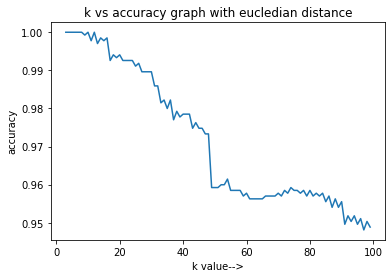

In [25]:
plt.plot(k_list,accuracy_list)
plt.xlabel('k value-->') 
# naming the y axis 
plt.ylabel('accuracy')
plt.title('k vs accuracy graph with eucledian distance')
plt.show()

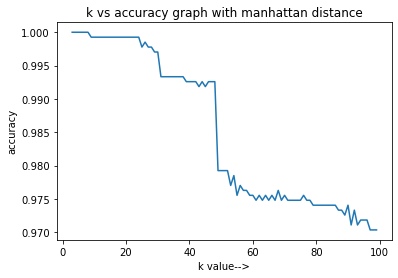

In [26]:
plt.plot(k_list2,accuracy_list2)
plt.xlabel('k value-->') 
# naming the y axis 
plt.ylabel('accuracy')
plt.title('k vs accuracy graph with manhattan distance')
plt.show()

# Testing

We need to do the same pre-processing as before on the Test Data as well

In [66]:
df_test=pd.read_csv("test.csv",header=None)
df_test_labels=pd.read_csv("test_labels.csv",header=None)
label_vals=df_test_labels.iloc[:,0].to_numpy()
letters={"a":int(ord('a')),"b":int(ord('b')),"c":int(ord('c')),"d":int(ord('d')),"e":int(ord('e')),"f":int(ord('f')),"g":int(ord('g')),"h":int(ord('h'))
                                             ,"i":int(ord('i')),"j":int(ord('j')),"k":int(ord('k')),"l":int(ord('l')),"m":int(ord('m')),"n":int(ord('n')),"o":int(ord('o')),"p":int(ord('p')),"q":int(ord('q')),"r":int(ord('r'))
                                             ,"s":int(ord('s')),"t":int(ord('t')),"u":int(ord('u')),"v":int(ord('v')),"w":int(ord('w')),"x":int(ord('x')),"y":int(ord('y')),"z":int(ord('z'))} 
for column in df_test.columns:
    df_test[column]=df_test[column].replace(to_replace ="?",  
                            value =df_test[column].mode()[0])
for column in df_test.columns:
    df_test[column]=df_test[column].replace(to_replace=letters)
for column in df_test_labels.columns:
    df_test_labels[column]=df_test_labels[column].replace(to_replace=letters)
test_vals=np.array(df_test)
label_vals=np.array(label_vals)

We got 100% accuracy for K=3 and K=5 on validation data.I am choosing K=5 for testing.

In [80]:
prediction=[]
for i in range(test_vals.shape[0]):
    indexes=KNeighbors(5,train_values,test_vals[i])
    result=find_majority(indexes,train_labels)
    prediction.append(result)
prediction=np.array(prediction)
acc = np.sum(prediction == label_vals)/prediction.shape[0]
predictions=[]
for i in range(0,len(prediction)):
    predictions.append(chr(prediction[i]))
labels=[]
for i in range(0,len(prediction)):
    labels.append(chr(label_vals[i]))
print("Accuracy:",acc)


Accuracy: 1.0


# Performance metrics:

# 1.Confusion matrix

A confusion matrix is a technique for summarizing the performance of a classification algorithm. Classification accuracy alone can be misleading if you have an unequal number of observations in each class or if you have more than two classes in your dataset.The left to right (primary)diagonal elements of a confusion matrix indicate the correct predictions and the off diagonal elements indicate the number of misclassifications

In [87]:
cm = confusion_matrix(labels, predictions)
print(cm)

[[505   0]
 [  0 495]]


The above confusion matrix shows that 595 values are correctly classified as 'e' class and an 495 values are classified correctly as 'p' class.There were no prediction errors.

# 2. F1-score

Precision is the number of True Positives divided by the number of True Positives and False Positives. Put another way, it is the number of positive predictions divided by the total number of positive class values predicted.

Recall is the number of True Positives divided by the number of True Positives and the number of False Negatives. Put another way it is the number of positive predictions divided by the number of positive class values in the test data. It is also called Sensitivity or the True Positive Rate.

The F1 Score is the 2*((precision * recall)/(precision+recall)).
The F1 score conveys the balance between the precision and the recall.The higher F1 score,the better.The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.

In [102]:
print(f1_score(labels, predictions,average='micro'))

1.0


# BaseLine Accuracy 

# 1.Random Guessing

In [126]:
random_classes=['e','p']
labels=[]
for i in range(0,len(random_results)):
    labels.append(chr(label_vals[i]))
for chances in range(0,10):
    random_results=[]
    for i in range(test_vals.shape[0]):
        result=random.choice(random_classes)
        random_results.append(result)
    random_results=np.array(random_results)
    acc = np.sum(random_results == labels)/random_results.shape[0]
    print(" Random guessing Accuracy : ",acc)

 Random guessing Accuracy :  0.499
 Random guessing Accuracy :  0.479
 Random guessing Accuracy :  0.49
 Random guessing Accuracy :  0.506
 Random guessing Accuracy :  0.46
 Random guessing Accuracy :  0.522
 Random guessing Accuracy :  0.518
 Random guessing Accuracy :  0.46
 Random guessing Accuracy :  0.52
 Random guessing Accuracy :  0.505


In this we randomly guess one of the classes from the list of all classes.From above we see that the accuracy with random guessing is on an average ~0.5 i.e 50% .This is a baseline score and a model is really poor if it fails to reach this accuracy.

#  2. Majority Voting

In [131]:
for chances in range(0,5):
    majority_results=[]
    for i in range(test_vals.shape[0]):
        result = Counter(train_labels).most_common()
        majority_results.append(result[0][0])
    majority_results=np.array(random_results)
    acc = np.sum(majority_results == labels)/majority_results.shape[0]
    print(" Majority Voting Accuracy : ",acc)

 Majority Voting Accuracy :  0.505
 Majority Voting Accuracy :  0.505
 Majority Voting Accuracy :  0.505
 Majority Voting Accuracy :  0.505
 Majority Voting Accuracy :  0.505


In this we return the class which has the highest number of occurance from the list of all classes.From above we see that the accuracy with Majority Voting is on an average ~0.5 i.e ~50% same as random guessing here because it has only two classes and the train data was well balanced.This is a baseline score and a model is really poor if it fails to reach this accuracy.

# Comparison with scikit-learn  KNN classifier

In [132]:
from sklearn.neighbors import KNeighborsClassifier
classifier=KNeighborsClassifier(n_neighbors=6,metric='minkowski',p=2)
classifier.fit(train_values,train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

In [138]:
sk_predictions=classifier.predict(test_vals)
sk_prediction=np.array(sk_predictions)
acc = np.sum(sk_prediction == label_vals)/sk_prediction.shape[0]
print(acc)

0.999


The scikit-learn KNN classifier gives 99.9 percent accuracy,which is equivalent to our KNN classifier above.